# Split data

In [1]:
# Importing modules
import pandas as pd
# Read data into papers
data = pd.read_csv('../data/eastmoney_bert.csv')
# data = pd.concat([data1, data2], axis=0)
print(len(data))
# Print head
data.head()

C:\Users\ZIQING002\AppData\Local\Temp\ipykernel_2204\3919460183.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/eastmoney_bert.csv')


KeyboardInterrupt: 

In [59]:
data = data[['item_title', 'year', 'month']]
data['year'] = data['year'].astype(int)
data['month'] = data['month'].astype(int)
data['year_month'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str) + '-01')

In [60]:
def split_data(data, start_time, end_time):
    # Create a 'year_month' column by combining 'year' and 'month'
    data['year_month'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str) + '-01')

    # Split the data based on the defined ranges
    splited_data = data[(data['year_month'] >= start_time) & (data['year_month'] <= end_time)]
    print(len(splited_data))
    return splited_data

In [62]:
train = split_data(data,'2017-01-01', '2022-06-30')
fit1 = split_data(data, '2022-07-01', '2022-09-30')
fit2 = split_data(data, '2022-10-01', '2022-12-31')
fit3 = split_data(data, '2023-01-01', '2023-03-31')
fit4 = split_data(data, '2023-04-01', '2023-08-31')

train.to_csv("./train.csv", index=False)
fit1.to_csv("./fit1.csv", index=False)
fit2.to_csv("./fit2.csv", index=False)
fit3.to_csv("./fit3.csv", index=False)
fit4.to_csv("./fit4.csv", index=False)


4320858
451944
423289
426113
981492


# Mine Topics with LDA

In [2]:
data = pd.read_csv('./train.csv')

In [15]:
import jieba
from gensim import corpora, models
import re

# 去除文本中的标点符号
def remove_punctuation(text):
    # 使用正则表达式去除标点
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r' ', '', text)
    return text

# 加载停用词列表
stop_words = set()
with open('./hit_stopwords.txt', 'r', encoding='utf-8') as file:  # 假设停用词列表文件名为 chinese_stop_words.txt
    for word in file:
        stop_words.add(word.strip())
def remove_stopwords(words):
    words = [word for word in words if word not in stop_words]
    return words

# eastmoney['sentiment_score'] 为情感得分列
# 分词处理
data['cut_titles'] = data['item_title'].apply(lambda x: remove_stopwords(list(jieba.cut(remove_punctuation(x)))))

In [16]:
data['cut_titles'].head()

0                        [平安, 银行, 年度, 派元]
1              [平安, 银行, 上半年, 净利润, 同比, 下降]
2          [平安, 银行, 主力, 净流入, 亿元, 两市, 排名第]
3    [平安, 银行, 主力, 资金, 连续, 天, 净流入, 累计, 亿元]
4          [平安, 银行, 主力, 净流入, 亿元, 两市, 排名第]
Name: cut_titles, dtype: object

In [17]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data['cut_titles'])
# Create Corpus
texts = data['cut_titles']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


In [18]:
from pprint import pprint
import numpy
import gensim.models
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=numpy.random.RandomState(10))
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.067*"万股" + 0.054*"股通" + 0.050*"累计" + 0.047*"连续" + 0.044*"减持" + 0.044*"万元" '
  '+ 0.033*"增持" + 0.032*"股东" + 0.032*"沪" + 0.027*"股份"'),
 (1,
  '0.215*"融资" + 0.112*"万元" + 0.084*"亿元" + 0.069*"余额" + 0.054*"偿还" + 0.052*"买入" '
  '+ 0.041*"信息" + 0.038*"融券" + 0.015*"股份" + 0.012*"科技"'),
 (2,
  '0.023*"公司" + 0.020*"股份" + 0.012*"净利润" + 0.010*"同比" + 0.010*"证券" + '
  '0.010*"科技" + 0.008*"快速" + 0.007*"约" + 0.006*"增长" + 0.006*"评级"')]


In [19]:
from tqdm import tqdm
# 如果需要将主题分布加入原DataFrame
data['topics'] = [lda_model[id2word.doc2bow(text)] for text in tqdm(data['cut_titles'], desc="Calculating topics")]

Calculating topics: 100%|██████████| 4320858/4320858 [09:32<00:00, 7550.45it/s]


In [20]:
# 为每个文档提取最大概率的主题，并加入DataFrame
dominant_topics = []
for topic_tuple in tqdm(data['topics'], desc="Extracting dominant topics"):
    if topic_tuple:  # 确保topics元组不为空
        topic_list = topic_tuple  # 获取主题概率列表
        if topic_list:  # 确保主题列表不为空
            dominant_topic = max(topic_list, key=lambda x: x[1])[0]
            dominant_topics.append(dominant_topic)
        else:
            dominant_topics.append(None)  # 如果没有主题，则添加None
    else:
        dominant_topics.append(None)  # 如果topics元组为空，添加None

data['dominant_topic'] = dominant_topics

Extracting dominant topics: 100%|██████████| 4320858/4320858 [00:03<00:00, 1213620.30it/s]


In [21]:
path = './eastmoney_topic1.csv'
data = data[['item_title','topics','dominant_topic', 'year','month']]
print(data.head())
# data.to_csv(path, index=False)
doc_lda.save('./lda_model.gensim')

                       item_title  \
0              平安银行2019年度10派2.18元   
1        平安银行：2020上半年净利润同比下降11.2%   
2  平安银行：主力净流入1.05亿元，两市排名第17（09-16   
3  平安银行：主力资金连续4天净流入累计4.11亿元（09-17   
4  平安银行：主力净流入3.09亿元，两市排名第14（09-18   

                                              topics  dominant_topic  year  \
0  [(0, 0.069995634), (1, 0.06736348), (2, 0.8626...               2  2020   
1  [(0, 0.05199994), (1, 0.047945883), (2, 0.9000...               2  2020   
2  [(0, 0.66676366), (1, 0.28648892), (2, 0.04674...               0  2020   
3  [(0, 0.92560095), (1, 0.0388861), (2, 0.035512...               0  2020   
4  [(0, 0.66666585), (1, 0.2865842), (2, 0.046749...               0  2020   

   month  
0      5  
1      8  
2      9  
3      9  
4      9  


c:\Users\ZIQING002\.virtualenvs\MTL-4YFQ4-cY\lib\site-packages\gensim\interfaces.py:92: UserWarning: corpus.save() stores only the (tiny) iteration object in memory; to serialize the actual corpus content, use e.g. MmCorpus.serialize(corpus)
  warnings.warn(


In [22]:
doc_lda.save('./lda_model.gensim')

c:\Users\ZIQING002\.virtualenvs\MTL-4YFQ4-cY\lib\site-packages\gensim\interfaces.py:92: UserWarning: corpus.save() stores only the (tiny) iteration object in memory; to serialize the actual corpus content, use e.g. MmCorpus.serialize(corpus)
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

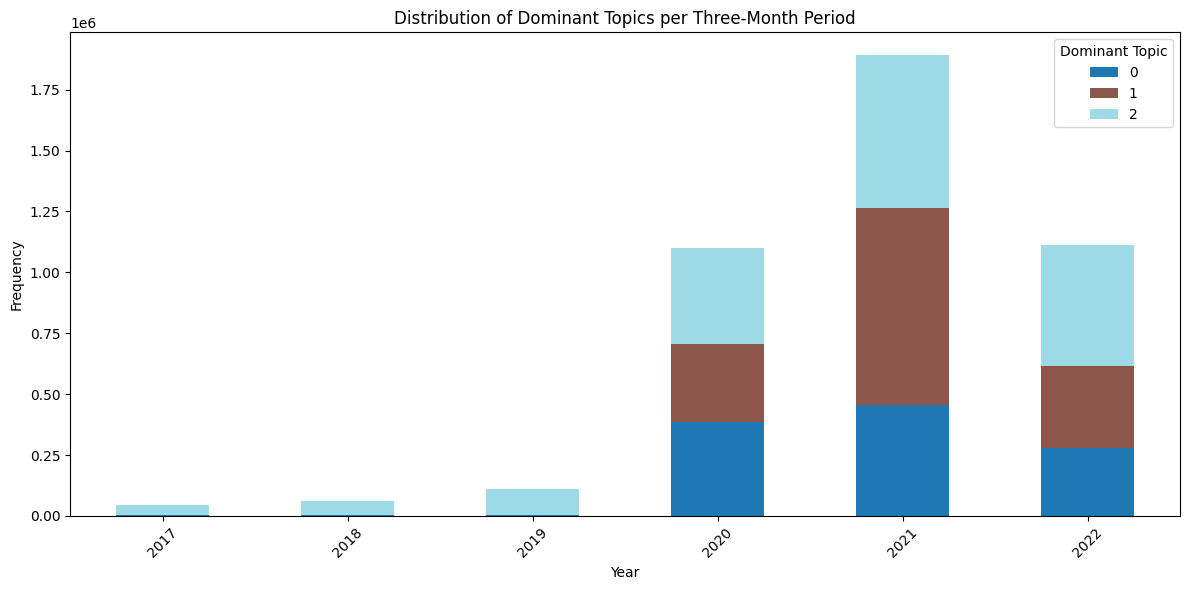

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Combine 'year' and 'month' into a datetime column
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str))

# Step 2: Create a "three-month period" column
data['period'] = data['date'].dt.to_period("Y")

# Step 3: Group by 'period' and 'dominant_topic', and count occurrences
topic_distribution = data.groupby(['period', 'dominant_topic']).size().unstack(fill_value=0)

# Step 4: Plot the distribution of dominant topics across three-month periods
plt.figure(figsize=(12, 6))
topic_distribution.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))

plt.title('Distribution of Dominant Topics per Three-Month Period')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Dominant Topic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Train Topic Classification Model

In [1]:
# only run if not continued from previous block
import pandas as pd
data = pd.read_csv('./eastmoney_topic1.csv')
data.head()


,item_title,topics,dominant_topic,year,month
0,平安银行2019年度10派2.18元,"[(0, 0.4513538), (1, 0.42719546), (2, 0.040402...",0,2020,5
1,平安银行：2020上半年净利润同比下降11.2%,"[(0, 0.028599624), (1, 0.029249543), (2, 0.028...",3,2020,8
2,平安银行：主力净流入1.05亿元，两市排名第17（09-16,"[(0, 0.025011698), (1, 0.49090013), (2, 0.4337...",1,2020,9
3,平安银行：主力资金连续4天净流入累计4.11亿元（09-17,"[(0, 0.020005248), (1, 0.72062945), (2, 0.0207...",1,2020,9
4,平安银行：主力净流入3.09亿元，两市排名第14（09-18,"[(0, 0.025011696), (1, 0.49087447), (2, 0.4338...",1,2020,9


In [24]:
import torch
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("Langboat/mengzi-bert-base-fin")
model = BertModel.from_pretrained("Langboat/mengzi-bert-base-fin").to(device)

c:\Users\ZIQING002\.virtualenvs\MTL-4YFQ4-cY\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
from tqdm import tqdm
def get_bert_embedding(titles, model, device, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(titles), batch_size)):
        batch_titles = titles[i:i+batch_size]
        inputs = tokenizer(batch_titles.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=32)
        inputs = {key:val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)

        embeddings.extend(batch_embeddings.cpu().numpy())
    return embeddings

In [27]:
data['title_embed'] = get_bert_embedding(data['item_title'], model, device, batch_size=64)

 23%|██▎       | 15398/67514 [20:26<1:09:12, 12.55it/s]


KeyboardInterrupt: 

In [9]:
print(data.head())

                       item_title  \
0              平安银行2019年度10派2.18元   
1        平安银行：2020上半年净利润同比下降11.2%   
2  平安银行：主力净流入1.05亿元，两市排名第17（09-16   
3  平安银行：主力资金连续4天净流入累计4.11亿元（09-17   
4  平安银行：主力净流入3.09亿元，两市排名第14（09-18   

                                              topics  dominant_topic  year  \
0  [(0, 0.4513538), (1, 0.42719546), (2, 0.040402...               0  2020   
1  [(0, 0.028599624), (1, 0.029249543), (2, 0.028...               3  2020   
2  [(0, 0.025011698), (1, 0.49090013), (2, 0.4337...               1  2020   
3  [(0, 0.020005248), (1, 0.72062945), (2, 0.0207...               1  2020   
4  [(0, 0.025011696), (1, 0.49087447), (2, 0.4338...               1  2020   

   month                                        title_embed  
0      5  [0.035107475, 0.042284798, -0.1718109, 0.03115...  
1      8  [0.12992123, 0.007185275, -0.1144319, -0.11513...  
2      9  [0.10176392, -0.037375703, -0.15134309, -0.133...  
3      9  [0.11925174, -0.07625077, -0.22930394, -0.1816... 

In [31]:
data.to_csv('./eastmoney_topic1.csv', index=False) #took long time

In [32]:
class LDADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, device):
        self.data = dataset
        self.device = device
        
    # get sample
    def __getitem__(self, idx):
        batch = self.data.iloc[idx,:]

        input = batch['title_embed']
        target = batch['dominant_topic']

        input = torch.tensor(input).to(self.device)
        target = torch.tensor(target).to(self.device)

        return input , target

    def __len__(self):
        return len(self.data)

In [33]:
from torch.utils.data import DataLoader

# Create a 'year_month' column by combining 'year' and 'month'
data['year_month'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str) + '-01')

# Define the date ranges for train, valid, and test sets
train_start = '2017-01-01'
train_end = '2022-03-31'
test_start = '2022-04-01'
test_end = '2022-06-30'

# Split the data based on the defined ranges
train_set = data[(data['year_month'] >= train_start) & (data['year_month'] <= train_end)]
test_set = data[(data['year_month'] >= test_start) & (data['year_month'] <= test_end)]
train_len, test_len = len(train_set), len(test_set)
print(train_len, test_len)

train_data = LDADataset(train_set, device)
test_data = LDADataset(test_set, device)

3772284 548574


In [34]:
# classifier hyper parameters 
bs = 64
lr = 0.001
input_size = 768  # Number of features
hidden_size = 128  # Hidden layer size
output_size = 3
dropout = 0.5

In [35]:
train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_data, batch_size=bs, shuffle=True)

In [36]:
import torch.nn as nn
import torch.nn.functional as F
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)  # Dropout layer for regularization

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [37]:
classifier = MLPClassifier(input_size, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropy for classification
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

In [38]:
# Training function
def train(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            optimizer.zero_grad()  # Zero out the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagate
            optimizer.step()  # Update the weights

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

In [39]:
# Train the model
train(classifier, train_loader, criterion, optimizer, epochs=20)

Training Epoch 0: 100%|██████████| 58942/58942 [19:27<00:00, 50.47it/s]


Epoch [1/20], Loss: 0.1512


Training Epoch 1: 100%|██████████| 58942/58942 [19:35<00:00, 50.14it/s]


Epoch [2/20], Loss: 0.1254


Training Epoch 2: 100%|██████████| 58942/58942 [19:32<00:00, 50.28it/s]


Epoch [3/20], Loss: 0.1165


Training Epoch 3: 100%|██████████| 58942/58942 [19:32<00:00, 50.26it/s]


Epoch [4/20], Loss: 0.1109


Training Epoch 4: 100%|██████████| 58942/58942 [19:32<00:00, 50.26it/s]


Epoch [5/20], Loss: 0.1073


Training Epoch 5: 100%|██████████| 58942/58942 [19:33<00:00, 50.23it/s]


Epoch [6/20], Loss: 0.1046


Training Epoch 6: 100%|██████████| 58942/58942 [19:33<00:00, 50.22it/s]


Epoch [7/20], Loss: 0.1025


Training Epoch 7: 100%|██████████| 58942/58942 [19:37<00:00, 50.04it/s]


Epoch [8/20], Loss: 0.1009


Training Epoch 8: 100%|██████████| 58942/58942 [19:32<00:00, 50.29it/s]


Epoch [9/20], Loss: 0.0995


Training Epoch 9: 100%|██████████| 58942/58942 [19:33<00:00, 50.21it/s]


Epoch [10/20], Loss: 0.0983


Training Epoch 10: 100%|██████████| 58942/58942 [19:31<00:00, 50.30it/s]


Epoch [11/20], Loss: 0.0974


Training Epoch 11: 100%|██████████| 58942/58942 [19:32<00:00, 50.26it/s]


Epoch [12/20], Loss: 0.0967


Training Epoch 12: 100%|██████████| 58942/58942 [19:32<00:00, 50.25it/s]


Epoch [13/20], Loss: 0.0961


Training Epoch 13: 100%|██████████| 58942/58942 [19:34<00:00, 50.18it/s]


Epoch [14/20], Loss: 0.0954


Training Epoch 14: 100%|██████████| 58942/58942 [19:34<00:00, 50.20it/s]


Epoch [15/20], Loss: 0.0951


Training Epoch 15: 100%|██████████| 58942/58942 [19:08<00:00, 51.32it/s]


Epoch [16/20], Loss: 0.0945


Training Epoch 16: 100%|██████████| 58942/58942 [19:49<00:00, 49.57it/s]


Epoch [17/20], Loss: 0.0942


Training Epoch 17: 100%|██████████| 58942/58942 [19:38<00:00, 50.00it/s]


Epoch [18/20], Loss: 0.0937


Training Epoch 18: 100%|██████████| 58942/58942 [19:35<00:00, 50.16it/s]


Epoch [19/20], Loss: 0.0938


Training Epoch 19: 100%|██████████| 58942/58942 [19:35<00:00, 50.16it/s]

Epoch [20/20], Loss: 0.0934


In [40]:
# Evaluation function
from sklearn.metrics import classification_report, accuracy_score
def evaluate(model, test_loader):
    model.eval()
    preds = []
    trues = []
    # correct = 0
    # total = 0
    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, labels in tqdm(test_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    # accuracy = 100 * correct / total
    # print(f'Accuracy: {accuracy:.2f}%')
    # 1. Classification Report: Precision, Recall, F1-Score per class
    report = classification_report(trues, preds, output_dict=True)
    print("Classification Report (Precision, Recall, F1 per class):\n")
    print(report)

    # 2. Overall Accuracy
    accuracy = accuracy_score(trues, preds)
    print("\nOverall Accuracy:", accuracy)

In [41]:
evaluate(classifier, test_loader)

100%|██████████| 8572/8572 [02:25<00:00, 58.98it/s]


Classification Report (Precision, Recall, F1 per class):

{'0': {'precision': 0.9686551082378294, 'recall': 0.9395947647212523, 'f1-score': 0.9539036594923735, 'support': 84198.0}, '1': {'precision': 0.953528153955809, 'recall': 0.7592508513053349, 'f1-score': 0.8453712480252766, 'support': 8810.0}, '2': {'precision': 0.9937805031873709, 'recall': 0.9885625488625286, 'f1-score': 0.9911646586345382, 'support': 207214.0}, '3': {'precision': 0.9347011244821464, 'recall': 0.9815406422068363, 'f1-score': 0.9575484241541062, 'support': 183430.0}, '4': {'precision': 0.951978279003582, 'recall': 0.8965065771233172, 'f1-score': 0.9234100951126836, 'support': 64922.0}, 'accuracy': 0.9641215223470306, 'macro avg': {'precision': 0.9605286337733474, 'recall': 0.9130910768438539, 'f1-score': 0.9342796170837957, 'support': 548574.0}, 'weighted avg': {'precision': 0.9645757912705631, 'recall': 0.9641215223470306, 'f1-score': 0.963845228225968, 'support': 548574.0}}

Overall Accuracy: 0.964121522347030

In [43]:
model_path = 'classifier.pth'

# Save the model's state dictionary
torch.save(classifier.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to classifier.pth


# Apply classifier on new data

In [80]:
import torch
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [81]:
import torch.nn as nn
import torch.nn.functional as F
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)  # Dropout layer for regularization

    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [82]:
classifier = MLPClassifier(input_size, hidden_size, output_size).to(device)
classifier.load_state_dict(torch.load('./classifier.pth'))
classifier.eval()  # Set to evaluation mode

MLPClassifier(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [84]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("Langboat/mengzi-bert-base-fin")
bert = BertModel.from_pretrained("Langboat/mengzi-bert-base-fin").to(device)

In [85]:
from tqdm import tqdm
def get_bert_embedding(titles, bert_model, device, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(titles), batch_size)):
        batch_titles = titles[i:i+batch_size]
        inputs = tokenizer(batch_titles.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=32)
        inputs = {key:val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)

        embeddings.extend(batch_embeddings.cpu().numpy())
    return embeddings

In [86]:
class TopicClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, device):
        self.data = dataset
        self.device = device
        
    # get sample
    def __getitem__(self, idx):
        batch = self.data.iloc[idx,:]

        input = batch['title_embed']
        # target = batch['dominant_topic']

        input = torch.tensor(input).to(self.device)
        # target = torch.tensor(target).to(self.device)

        return input

    def __len__(self):
        return len(self.data)

In [87]:
def predict_topic(data_loader, model):
    preds = []
    with torch.no_grad():  # Disable gradient computation for inference
        for inputs in tqdm(data_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().numpy())
    return preds

In [121]:
def classify_topics(in_data_path, out_data_path, device, classifier_model, bert_model):
    data = pd.read_csv(in_data_path)
    print(len(data), data.columns)
    print('generate title embedding')
    data['title_embed'] = get_bert_embedding(data['item_title'], bert_model, device, batch_size=64)
    print('classify model topic')
    data_loader = DataLoader(TopicClassifierDataset(data, device), batch_size=64, shuffle=False)
    topics = predict_topic(data_loader, classifier_model)
    data['dominant_topic'] = topics
    print('save results')
    data.to_csv(out_data_path, index=False)

In [95]:
classify_topics('./fit1.csv', './eastmoney_topic2.csv', device, classifier_model=classifier, bert_model=bert)

451944 Index(['item_title', 'year', 'month', 'year_month'], dtype='object')
generate title embedding


100%|██████████| 7062/7062 [09:29<00:00, 12.40it/s]


classify model topic


100%|██████████| 7062/7062 [01:21<00:00, 86.79it/s]


In [102]:
classify_topics('./fit2.csv', './eastmoney_topic3.csv', device, classifier_model=classifier, bert_model=bert)

423289 Index(['item_title', 'year', 'month', 'year_month'], dtype='object')
generate title embedding


100%|██████████| 6614/6614 [08:49<00:00, 12.48it/s]


classify model topic


100%|██████████| 6614/6614 [01:13<00:00, 90.11it/s] 


save results


In [122]:
classify_topics('./fit3.csv', './eastmoney_topic4.csv', device, classifier_model=classifier, bert_model=bert)

426113 Index(['item_title', 'year', 'month', 'year_month'], dtype='object')
generate title embedding


100%|██████████| 6659/6659 [08:45<00:00, 12.67it/s]


classify model topic


100%|██████████| 6659/6659 [01:15<00:00, 88.44it/s]


save results


In [112]:
classify_topics('./fit4.csv', './eastmoney_topic5.csv', device, classifier_model=classifier, bert_model=bert)

981492 Index(['item_title', 'year', 'month', 'year_month'], dtype='object')
generate title embedding


100%|██████████| 15336/15336 [20:02<00:00, 12.76it/s]


classify model topic


100%|██████████| 15336/15336 [02:48<00:00, 90.99it/s]


save results


In [131]:
columns_to_load = ['item_title', 'year', 'month', 'dominant_topic']
fit1 = pd.read_csv('./eastmoney_topic2.csv', usecols=columns_to_load)
fit2 = pd.read_csv('./eastmoney_topic3.csv', usecols=columns_to_load)
fit3 = pd.read_csv('./eastmoney_topic4.csv', usecols=columns_to_load)
fit4 = pd.read_csv('./eastmoney_topic5.csv', usecols=columns_to_load)
data = pd.concat([fit1, fit2, fit3, fit4], axis=0)

<Figure size 1200x600 with 0 Axes>

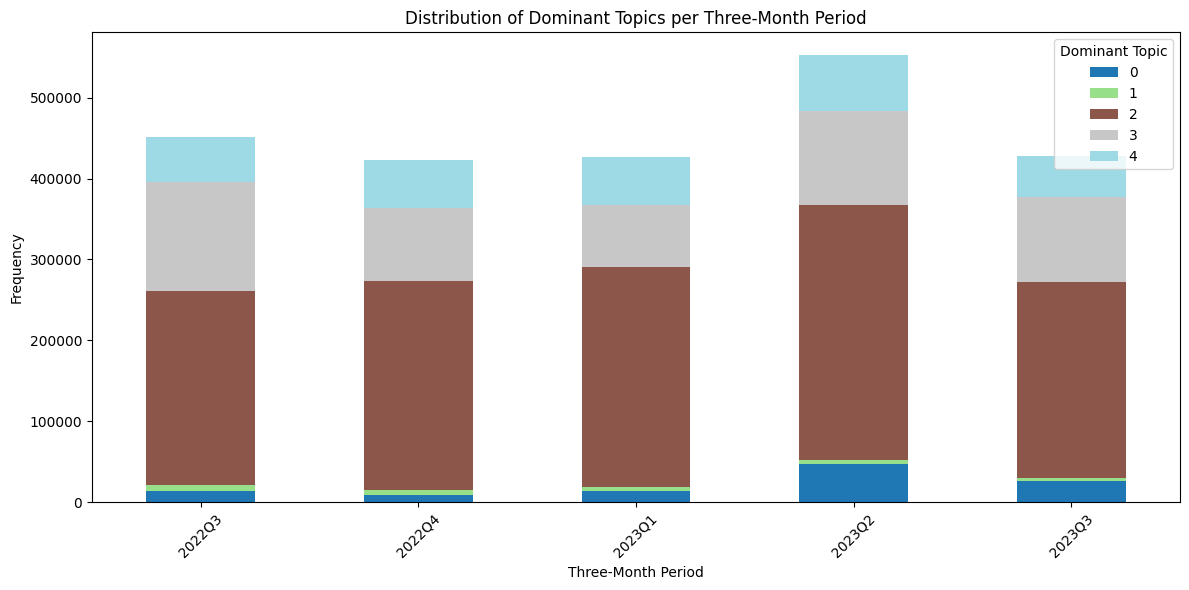

In [132]:
# plot fitted topic distribution

# Step 1: Combine 'year' and 'month' into a datetime column
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month'].astype(str))

# Step 2: Create a "three-month period" column
data['period'] = data['date'].dt.to_period("Q")

# Step 3: Group by 'period' and 'dominant_topic', and count occurrences
topic_distribution = data.groupby(['period', 'dominant_topic']).size().unstack(fill_value=0)

# Step 4: Plot the distribution of dominant topics across three-month periods
plt.figure(figsize=(12, 6))
topic_distribution.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))

plt.title('Distribution of Dominant Topics per Three-Month Period')
plt.xlabel('Three-Month Period')
plt.ylabel('Frequency')
plt.legend(title='Dominant Topic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [133]:
train = pd.read_csv('./eastmoney_topic1.csv', usecols=columns_to_load)
data = pd.concat([train, data], axis=0)
data.to_csv('eastmoney_topic.csv',index=False)

In [136]:
print(len(data))
print(data.columns)

6603696
Index(['item_title', 'dominant_topic', 'year', 'month', 'date', 'period'], dtype='object')


# Compute sentiment using FinBert

In [151]:
data = pd.read_csv('../data/eastmoney_bert.csv')

C:\Users\ZIQING002\AppData\Local\Temp\ipykernel_46632\1788611792.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/eastmoney_bert.csv')


In [152]:
data.columns

Index(['item_title', 'item_author', 'article_author', 'article_source',
       'item_views', 'item_comment_counts', 'article_likes', 'year', 'month',
       'eastmoney_robo_journalism', 'media_robo_journalism',
       'SMA_robo_journalism', 'viral', 'article_source_cate',
       'item_author_cate', 'sentiment_score', 'cut_titles', 'topics',
       'dominant_topic', 'topics_val', 'stock_code', 'topics_val1',
       'topics_val2', 'topics_val3', 'topics_val4', 'topics_val5',
       'topics_val6', 'topics_val7', 'topics_val8'],
      dtype='object')

In [162]:
from transformers import TextClassificationPipeline
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BertTokenizerFast
model_path="yiyanghkust/finbert-tone-chinese"
new_model = AutoModelForSequenceClassification.from_pretrained(model_path,output_attentions=True)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
PipelineInterface = TextClassificationPipeline(model=new_model, tokenizer=tokenizer, return_all_scores=True, device=device)
titles, scores, labels = [], [], []
for _, row in tqdm(data.sample(n=1000).iterrows(), desc="Score sentiment"):
    titles.append(row['item_title'])
    label = PipelineInterface(row['item_title'])
    highest_score_label = max(label[0], key=lambda x: x['score'])['label']
    scores.append(row['sentiment_score'])
    labels.append(highest_score_label)

df = pd.DataFrame({
    'title': titles,
    'Original Dict Score': scores,
    'New FinBert Categorization': labels
})
df.to_csv('./sentiment_comparison.csv', index=False)

c:\Users\ZIQING002\.virtualenvs\MTL-4YFQ4-cY\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Score sentiment: 1000it [00:16, 59.95it/s]


,title,Original Dict Score,New FinBert Categorization
0,宝鹰股份(002047)融资融券信息(05-19),0.146426,Neutral
1,四川路桥10月19日获沪股通增持198.89万股,-0.040335,Neutral
2,四川路桥盘前必读(09-28),0.016736,Neutral
3,铂力特本周融资净偿还1368.3万元，居通用设备板块第六,0.004530,Neutral
4,共进股份：主力资金连续3天净流出累计1701.78万元（01,0.105217,Negative
...,...,...,...
995,日月明：主力资金净流出1.16亿元，净占比-17.20%（02-,0.059895,Neutral
996,中核钛白：连续6日融资净买入累计3133.78万元（01-20,0.100460,Neutral
997,益丰药房：“益丰转债”赎回登记日3月4日 3月5日起停,-0.131958,Neutral
998,嘉寓股份：融资净买入64.46万元，融资余额1972万元（0,0.145315,Neutral


In [171]:
df.head(20)

,title,Original Dict Score,New FinBert Categorization
0,宝鹰股份(002047)融资融券信息(05-19),0.146426,Neutral
1,四川路桥10月19日获沪股通增持198.89万股,-0.040335,Neutral
2,四川路桥盘前必读(09-28),0.016736,Neutral
3,铂力特本周融资净偿还1368.3万元，居通用设备板块第六,0.004530,Neutral
4,共进股份：主力资金连续3天净流出累计1701.78万元（01,0.105217,Negative
5,高测股份：主力资金连续4天净流出累计2422.75万元（10,0.063107,Negative
6,绿地控股08月19日被沪股通减持426.28万股,-0.243129,Neutral
7,苏垦农发12月22日被沪股通减持234.58万股,-0.196365,Neutral
8,申联生物本周融资净买入306.56万元，居农药兽药板块第,0.272708,Neutral
9,新元科技从传统制造商向高端智能制造业转型,0.320457,Neutral


In [173]:
from transformers import TextClassificationPipeline
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BertTokenizerFast
model_path="yiyanghkust/finbert-tone-chinese"
new_model = AutoModelForSequenceClassification.from_pretrained(model_path,output_attentions=True)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
PipelineInterface = TextClassificationPipeline(model=new_model, tokenizer=tokenizer, return_all_scores=True, device=device)
titles, scores, labels = [], [], []
for _, row in tqdm(data.iterrows(), total=len(data), desc="Score sentiment"):
    titles.append(row['item_title'])
    label = PipelineInterface(row['item_title'])
    highest_score_label = max(label[0], key=lambda x: x['score'])['label']
    scores.append(row['sentiment_score'])
    labels.append(highest_score_label)

df = pd.DataFrame({
    'title': titles,
    'sentiment_score': scores,
    'sentiment_label': labels
})
df.to_csv('./sentiment_score.csv', index=False)

c:\Users\ZIQING002\.virtualenvs\MTL-4YFQ4-cY\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Score sentiment: 100%|██████████| 6603696/6603696 [28:42:31<00:00, 63.90it/s]   


In [175]:
df['sentiment_label'].value_counts()

sentiment_label
Neutral     5068124
Positive    1036911
Negative     498661
Name: count, dtype: int64

In [176]:
len(df)

6603696